In [1]:
import numpy as np
import fitsio
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from matplotlib.lines import Line2D

import seaborn as sb
plt.style.use('seaborn')
sb.set_context("notebook", font_scale=1.5)
    
%load_ext autoreload
%autoreload 2

In [2]:
def plot_mean_mag_response(t, name, corrected, ylim=[-.5, .5], x_type='mag', run_name='', title=True, mmag=True,
                           ylabel=None, cmap=None, xmax=None, use_one_error=False, dx=None):
    sb.set_style("whitegrid")

#     mmin, mmax = 18, 24.5
#     dm = 0.5
#     mags = np.arange(mmin, mmax+dm, dm)

#     x = np.mean([mags[:-1], mags[1:]], axis=0)

    SMALL_SIZE = 16
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 22

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:purple']
    
    med_marker = 'D' # For median

    if dx is None:
        if x_type == 'mag':
            dx = .1
        elif x_type == 's2n':
            dx = 1
        
    if mmag is True:
        sf = 1000.
        mlabel = 'mmag'
    else:
        sf = 1.
        mlabel = 'mag'

    k = 0
    for b in 'griz':
        spacing = t[f'bin_mean_{b}'][1] - t[f'bin_mean_{b}'][0]
        xbin = t[f'bin_mean_{b}'] - spacing / 2
        if xmax is not None:
            cuts = np.where(xbin < xmax)
        else:
            cuts = np.where(xbin > 0)
        
        if cmap is not None:
            if isinstance(cmap, str):
                c = sb.color_palette(cmap, 4)[k]
            else:
                c = cmap[k]
        else:
            c = colors[k]
        
        if use_one_error is True:
            plt.plot(xbin[cuts] + dx*k, sf*t[f'mean_{b}'][cuts], 'o', label=f'{b}', color=c)
        else:
            plt.errorbar(xbin[cuts] + dx*k, sf*t[f'mean_{b}'][cuts], sf*t[f'std_{b}'][cuts], label=f'{b}', fmt='o', color=c)#color=c[k])

        if k == 0:
            lab = 'median'
        else:
            lab = None
        plt.scatter(xbin[cuts] + dx*k, sf*t[f'med_{b}'][cuts], facecolor='none', edgecolor=c, label=lab, s=40, linewidths=1.5, marker=med_marker)

        k += 1

    plt.axhline(0, lw=2, ls='--', c='k')
    
    xlim = plt.gca().get_xlim()
    val = 5
    plt.fill_between([xlim[0], xlim[1]], [-val, -val], [val, val], color='gray', alpha=0.15)
    
#     if xmax is not None:
#         if xlim[1] > xmax:
#             xlim = (xlim[0], xmax)
#             plt.xlim(xlim)
    
    plt.xlim(xlim)

    if corrected is True:
        l = '_deredden'
    else:
        l = ''
        
    if name == 'Galaxy':
        if x_type == 'mag':
            plt.xlabel(f'True bdf_mag{l}')
        elif x_type == 's2n':
            plt.xlabel(f'Meas band s2n')
        plt.ylabel(r'$<\Delta m_\mathrm{DF}>$ ' +f'({mlabel})')
    elif name == 'Star':
        if x_type == 'mag':
            plt.xlabel(r'True $\delta$-mag')
        elif x_type == 's2n':
            plt.xlabel(f'Meas band s2n')
        plt.ylabel(r'$<\Delta m_\delta>$ ' +f'({mlabel})')
        
    if ylabel == 'grid':
#         plt.ylabel(r'$<\Delta \text{mag}>$ ' +f'({mlabel})')
        plt.ylabel('Meas - True mag (cm-bdf); (mmag)')
        
    plt.ylim(ylim)
    
    if x_type == 'mag':
        plt.gcf().set_size_inches(9, 9)
        loc = 'upper left'
    elif x_type == 's2n':
        plt.axvline(5-dx, lw=2, ls='--', c='k')
        plt.gcf().set_size_inches(18, 9)
        loc = 'upper right'
        
    if cmap is not None:
        cc = sb.color_palette(cmap, 4)
        custom_lines = [Line2D([0], [0], color=cc[0], lw=4),
                        Line2D([0], [0], color=cc[1], lw=4),
                        Line2D([0], [0], color=cc[2], lw=4),
                        Line2D([0], [0], color=cc[3], lw=4)]

        l1 = plt.legend(custom_lines, ['g', 'r', 'i', 'z'], ncol=2, bbox_to_anchor =(0.35, 0.9),)

    else:
        l1 = plt.legend(loc=loc, ncol=2)
    
    p1 = plt.scatter([1], [1], facecolor='k')
    p2 = plt.scatter([1], [1], facecolor='none', edgecolor='k', marker=med_marker)
    l2 = plt.legend([p1, p2], ['Mean', 'Median'], loc='upper left', ncol=2, columnspacing=1, handletextpad=0.25)
    
    plt.xlim(xlim)
    
    plt.gca().add_artist(l1)
    
    # Function add a legend
#     plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2) 

    if title is True:
        plt.title(f'Balrog {run_name} {name} Magnitude Response')
        
    return

class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [3]:
t_gal_file = './tables/gal-scatter-mag-stats-deredden.fits'
t_gal = Table.read(t_gal_file)

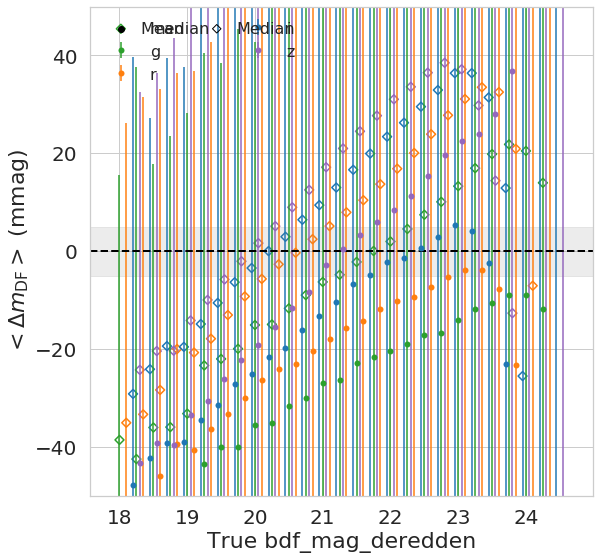

In [5]:
plot_mean_mag_response(t_gal, name='Galaxy', corrected=True, title=None, ylim=[-50, 50])
# plt.gcf().savefig('./figs/gals-mean-mag-response.pdf', bbox_inches='tight')

In [4]:
t_gal_s2n_file = './tables/gal-scatter-mag-stats-deredden-s2n.fits'
t_gal_s2n = Table.read(t_gal_s2n_file)

Text(0.5, 1.0, 'Balrog Galaxy Magnitude Response')

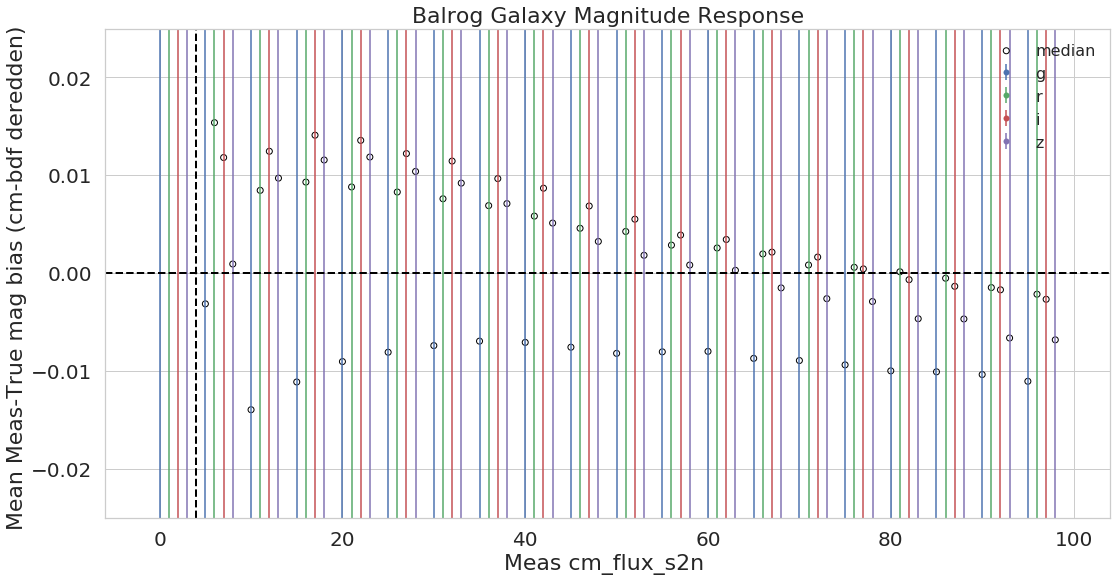

In [10]:
# def plot_
sb.set_style("whitegrid")

t = t_gal_s2n

corrected = True

mmin, mmax = 0, 100
dm = 5
# mags = np.arange(mmin, mmax+dm, dm)
# mags = np.arange(mmin, mmax+dm, dm)
mags = np.arange(mmin, mmax, dm)

# mag_means = np.mean([mags[:-1], mags[1:]], axis=0)

dx = 1

k = 0
for b in 'griz':
    plt.errorbar(mags + dx*k, t[f'mean_{b}'], t[f'std_{b}'], label=b, fmt='o')
    
    if k == 0:
        lab = 'median'
    else:
        lab = None
    plt.scatter(mags + dx*k, t[f'med_{b}'], facecolor='none', edgecolor='k', label=lab)
    
    k += 1
    
plt.axhline(0, lw=2, ls='--', c='k')
plt.axvline(5-dx, lw=2, ls='--', c='k')

if corrected is True:
    l = ''
else:
    l = '(Uncorrected)'

plt.xlabel(f'Meas cm_flux_s2n {l}')
plt.ylabel(f'Mean Meas-True mag bias (cm-bdf deredden) {l}')
    
plt.ylim([-.025, .025])

plt.legend(loc='upper right')
plt.gcf().set_size_inches(18, 9)

plt.title('Balrog Galaxy Magnitude Response')

In [39]:
t

mean_g,med_g,std_g,mean_r,med_r,std_r,mean_i,med_i,std_i,mean_z,med_z,std_z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-0.0644889804052278,-0.04099047342789319,0.0918652189821954,-0.05343858642504639,-0.034079364108798416,0.08258550027490222,-0.04437008810310169,-0.02610059046559421,0.07705467266650286,-0.04104369235924035,-0.02192585147058068,0.07571453611721388
-0.05672999235587371,-0.03601933442596561,0.07775331654891507,-0.042316156190470786,-0.023598369467723757,0.07742135327069302,-0.03911451679800129,-0.019495716197653223,0.0774965929527835,-0.036314996007931324,-0.016921219658254216,0.08330630798226991
-0.04858901893041963,-0.02708139813312016,0.08380199249388168,-0.03834257529417797,-0.019145274464381856,0.07848663053088122,-0.03278657436114241,-0.012361335683600316,0.0854929705512867,-0.02805762033872982,-0.007621500457819508,0.0967849401808195
-0.04002603935695235,-0.020721143350925786,0.08247043033383904,-0.031474830449816645,-0.010863597620545562,0.08761624773626112,-0.02596481847537636,-0.004728184650968359,0.10325773284999192,-0.020487029064508864,-4.6752777251413136e-05,0.11074947153185426
-0.035279349583552035,-0.015032362649385789,0.0893211788343136,-0.025161798170750517,-0.004013713542828867,0.10504023703703312,-0.02058837387282316,0.0015560363438620328,0.11514329873390972,-0.013302080446992574,0.0070895955988810044,0.13038234651368746
-0.030770046300108215,-0.010239739863990849,0.10153116115238839,-0.021592135792536247,0.0011235463590395511,0.11624071306866064,-0.01451709673775425,0.007937508405724714,0.1366024453479215,-0.0052490460534554756,0.014872076846767612,0.15773227254701147
-0.026514134898891855,-0.005462316911220455,0.11184604294952981,-0.016697876550778572,0.006563234657594563,0.14152337477247698,-0.008309059110795271,0.01488492274737041,0.15926612455793085,0.0020554664098143623,0.022778265381074192,0.18509512874929832
-0.02219814680146652,-0.001028162772907848,0.1385712089969801,-0.012872427753629494,0.01214550113588686,0.16525938317442457,-0.003369685312848418,0.021719982726693843,0.18309296781335904,0.007271314436356725,0.02939240716356295,0.22025324306538108
-0.01966644123364247,0.003308286197654553,0.16369092985372027,-0.009799371764934244,0.01851467234373061,0.18714039306439864,-0.0002892428409259992,0.02787576293912508,0.21322896522004092,0.0134593908760179,0.0350472759632936,0.27461534628988366


In [37]:
mags.shape

(14,)

In [72]:
low = sof[sof['meas_cm_s2n_r'] <= 5]
print(len(low))

NameError: name 'sof' is not defined

Text(0.5, 0, 'Median offsets (mmag)')

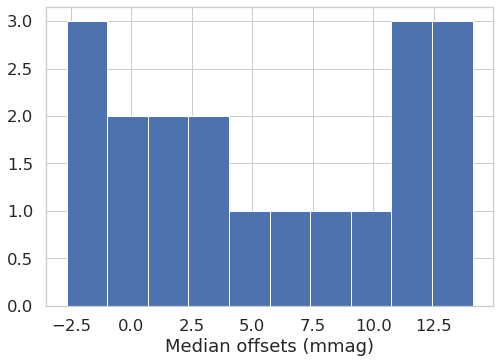

In [64]:
plt.hist(1000*t[f'med_i'])
plt.xlabel('Median offsets (mmag)')

### Stars

In [46]:
t_star_file = './tables/star-scatter-mag-stats-meas_cm_magderedden.fits'
t_star = Table.read(t_star_file)

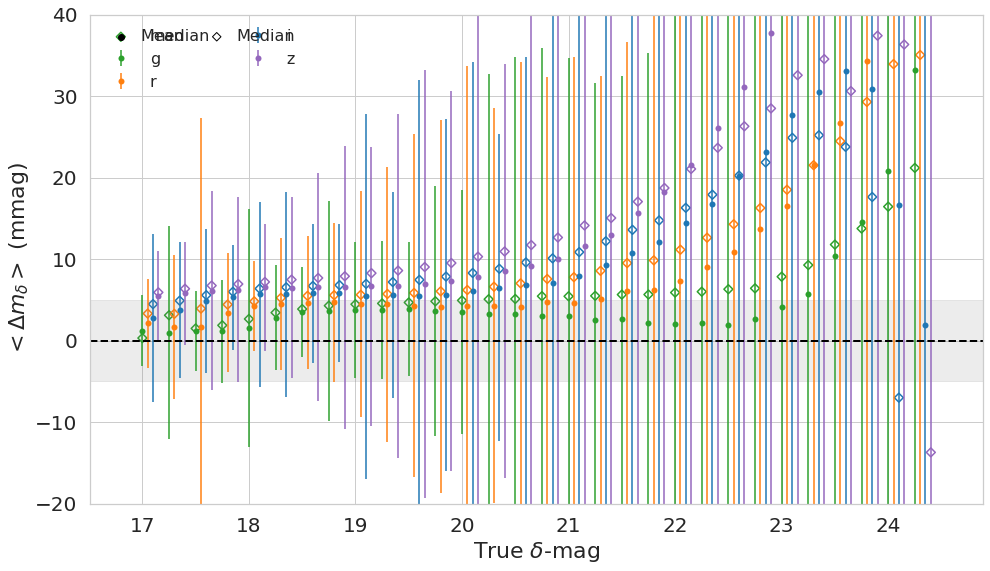

In [22]:
plot_mean_mag_response(t_star, name='Star', corrected=True, ylim=[-20, 40], title=None, mmag=True, dx=.05)
plt.gcf().set_size_inches(16, 9)
plt.gcf().savefig('./figs/stars-mean-mag-response.pdf', bbox_inches='tight')

In [16]:
t_star

mean_g,med_g,std_g,bin_mean_g,mean_r,med_r,std_r,bin_mean_r,mean_i,med_i,std_i,bin_mean_i,mean_z,med_z,std_z,bin_mean_z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.001236133162680505,0.0003256990696929307,0.004377118492630675,17.125,0.0021130351825703144,0.0033297218611707535,0.005399946096609634,17.125,0.0027978257745352713,0.004490218997231565,0.010279569713682102,17.125,0.005447205233712108,0.005930366993720071,0.00559825206301448,17.125
0.0009978719629462063,0.0031216360797614584,0.01308042936127153,17.375,0.0016854521096228638,0.0032922643596027257,0.008785418645218706,17.375,0.0037633171919017367,0.004911378038382708,0.008378261423907397,17.375,0.005794626075496148,0.006372093139983548,0.00632674760268327,17.375
0.001149175141985169,0.001505305747414809,0.004898452127068168,17.625,0.0016433858209906106,0.00394112915973821,0.025695625174676346,17.625,0.004861159606931803,0.005586631696413491,0.008808887566128187,17.625,0.006114451758145018,0.006760501611443814,0.012213534710281282,17.625
0.0011714904561159658,0.0018892619454575765,0.006335843364118706,17.875,0.003409059677606985,0.004434296544122418,0.007301877024872732,17.875,0.005339328942775738,0.006007165222040811,0.0064605880274177865,17.875,0.00625719347250633,0.006951802683488495,0.01137897614741886,17.875
0.0015853138366630647,0.002669897059055515,0.01461185427493855,18.125,0.004203861772512581,0.00483124221490705,0.0055226685084338945,18.125,0.005697701306723629,0.006387864453284209,0.011330742897769513,18.125,0.006539653851256595,0.007209326696047569,0.007819997906737179,18.125
0.002816997554702669,0.003442400439631399,0.0064233773707742725,18.375,0.004530857228281501,0.005257292793963586,0.008120899846687927,18.375,0.005687888261489232,0.006554451376779014,0.012602278314096995,18.375,0.006489188784994303,0.007488822378935112,0.01109294431828017,18.375
0.0035342108695965596,0.0038812926610809484,0.005564432879796476,18.625,0.00467390976573752,0.005502879101142,0.008190903791467441,18.625,0.005797881319367888,0.006713269226771956,0.008566769733564655,18.625,0.006572070546111385,0.007696027822024831,0.013946509414960416,18.625
0.0036854734151580246,0.004297186590711988,0.01350666794812159,18.875,0.00470710474891256,0.0055819657747306906,0.009762988945812588,18.875,0.005840499320968564,0.0068195942648863195,0.008442716039208417,18.875,0.006530206764712218,0.00790354177294006,0.017296178626566065,18.875
0.003792990723634072,0.004473261928531258,0.008351643167681192,19.125,0.004536477783932698,0.005632481166053083,0.013851138973531723,19.125,0.005455787296630848,0.00697375290913449,0.022397674641013214,19.125,0.006649646901634877,0.008287208327928397,0.01715360667559782,19.125


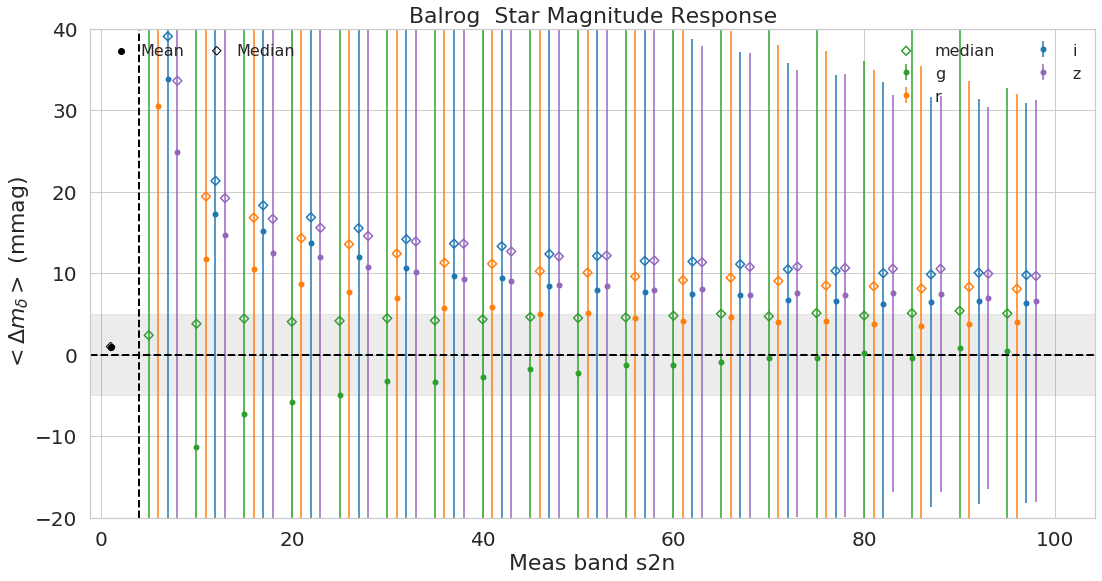

In [23]:
t_star_s2n_file = './tables/stars-scatter-mag-stats-deredden-s2n.fits'
t_star_s2n = Table.read(t_star_s2n_file)
plot_mean_mag_response(t_star_s2n, name='Star', corrected=True, ylim=[-20, 40], x_type='s2n')

In [113]:
np.arange(0, 10, 5).shape

(2,)

### Grid Test

In [14]:
def plot_mean_mag_response_grid(t, name, corrected, ylim=[-.5, .5], x_type='mag', run_name='', title=True, mmag=True,
                           ylabel=None, cmap=None, xmax=None, use_one_error=False, dx=None, bar_alpha=0.125):
    sb.set_style("whitegrid")

#     mmin, mmax = 18, 24.5
#     dm = 0.5
#     mags = np.arange(mmin, mmax+dm, dm)

#     x = np.mean([mags[:-1], mags[1:]], axis=0)

    SMALL_SIZE = 18
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 22

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
    
    med_marker = 'D' # For median

    if dx is None:
        if x_type == 'mag':
            dx = .1
        elif x_type == 's2n':
            dx = 1
        
    if mmag is True:
        sf = 1000.
        mlabel = 'mmag'
    else:
        sf = 1.
        mlabel = 'mag'

    k = 0
    for b in 'griz':
        spacing = t[f'bin_mean_{b}'][1] - t[f'bin_mean_{b}'][0]
        xbin = t[f'bin_mean_{b}'] - spacing / 2
        if xmax is not None:
            cuts = np.where(xbin < xmax)
        else:
            cuts = np.where(xbin > 0)
        
        if cmap is not None:
            if isinstance(cmap, str):
                c = sb.color_palette(cmap, 4)[k]
            else:
                c = cmap[k]
        else:
            c = colors[k]
        
        if use_one_error is True:
            plt.plot(xbin[cuts] + dx*(k+1), sf*t[f'mean_{b}'][cuts], 'o', label=f'{b}', color=c)
        else:
            plt.errorbar(xbin[cuts] + dx*k, sf*t[f'mean_{b}'][cuts], sf*t[f'std_{b}'][cuts], label=f'{b}', fmt='o', color=c)#color=c[k])

        if k == 0:
            lab = 'median'
        else:
            lab = None
        plt.scatter(xbin[cuts] + dx*(k+1), sf*t[f'med_{b}'][cuts], facecolor='none', edgecolor=c, label=lab, s=40, linewidths=1.5, marker=med_marker)

        k += 1

    plt.axhline(0, lw=2, ls='--', c='k')
    
    xlim = plt.gca().get_xlim()
    val = 5
    
    plt.fill_between([xlim[0], xlim[1]], [-val, -val], [val, val], color='gray', alpha=0.25)
    
    if use_one_error is True:
        mean_bias = np.mean([t['mean_g'][cuts],
                            t['mean_r'][cuts],
                            t['mean_i'][cuts],
                            t['mean_z'][cuts]], axis=0)
        mean_err = np.mean([t['std_g'][cuts],
                            t['std_r'][cuts],
                            t['std_i'][cuts],
                            t['std_z'][cuts]], axis=0)
                
        for k in range(len(mean_bias)):
            xx = [xbin[cuts][k], xbin[cuts][k]+spacing]
            y1 = 1000.*np.array([mean_bias[k]-mean_err[k], mean_bias[k]-mean_err[k]])
            y2 = 1000.*np.array([mean_bias[k]+mean_err[k], mean_bias[k]+mean_err[k]])
            plt.fill_between(xx, y1, y2, color='tab:blue', alpha=bar_alpha)
        
#     if xmax is not None:
#         if xlim[1] > xmax:
#             xlim = (xlim[0], xmax)
#             plt.xlim(xlim)
    
    plt.xlim(xlim)

    if corrected is True:
        l = '_deredden'
    else:
        l = ''
        
    if name == 'Galaxy':
        if x_type == 'mag':
            plt.xlabel(f'True mag (bdf)')
        elif x_type == 's2n':
            plt.xlabel(f'Meas band s2n')
        plt.ylabel(r'$<\Delta m_\mathrm{DF}>$ ' +f'({mlabel})')
    elif name == 'Star':
        if x_type == 'mag':
            plt.xlabel(r'True $\delta$-mag')
        elif x_type == 's2n':
            plt.xlabel(f'Meas band s2n')
        plt.ylabel(r'$<\Delta m_\delta>$ ' +f'({mlabel})')
        
    if ylabel == 'grid':
#         plt.ylabel(r'$<\Delta \text{mag}>$ ' +f'({mlabel})')
        plt.ylabel('Measured-True mag (cm-bdf; mmag)')
        
    plt.ylim(ylim)
    
    if x_type == 'mag':
        plt.gcf().set_size_inches(9, 9)
        loc = 'upper left'
    elif x_type == 's2n':
        plt.axvline(5-dx, lw=2, ls='--', c='k')
        plt.gcf().set_size_inches(18, 9)
        loc = 'upper right'
        
    if cmap is not None:
        cc = sb.color_palette(cmap, 4)
        custom_lines = [Line2D([0], [0], color=cc[0], lw=4),
                        Line2D([0], [0], color=cc[1], lw=4),
                        Line2D([0], [0], color=cc[2], lw=4),
                        Line2D([0], [0], color=cc[3], lw=4)]

        l1 = plt.legend(custom_lines, ['g', 'r', 'i', 'z'], ncol=2, loc='center left', bbox_to_anchor=(0.0275, 0.875))

    else:
        l1 = plt.legend(loc=loc, ncol=2)
        
    if use_one_error is True:
        p1 = [Line2D([0], [0], color='tab:blue', lw=12, alpha=bar_alpha)]
        l2 = plt.legend(p1, ['Mean std'], loc='center left', bbox_to_anchor=(0.0275, 0.8))
    
    p1 = plt.scatter([1], [1], facecolor='k')
    p2 = plt.scatter([1], [1], facecolor='none', edgecolor='k', marker=med_marker)
    l3 = plt.legend([p1, p2], ['Mean', 'Median'], loc='upper left', ncol=2, columnspacing=1, handletextpad=0.25) 
    
    plt.xlim(xlim)
    
    plt.gca().add_artist(l1)
    
    if use_one_error is True:
        plt.gca().add_artist(l2)
    
    # Function add a legend
#     plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2) 

    if title is True:
        plt.title(f'Balrog {run_name} {name} Magnitude Response')
        
    return

In [6]:
dt = True
if dt is True:
    lt = '_dt'
else:
    lt = ''
t_grid_file = f'./tables/grid-gal-scatter-mag-stats-deredden{lt}.fits'
t_grid = Table.read(t_grid_file)

In [167]:
np.arange(20)[2:18:2]

array([ 2,  4,  6,  8, 10, 12, 14, 16])

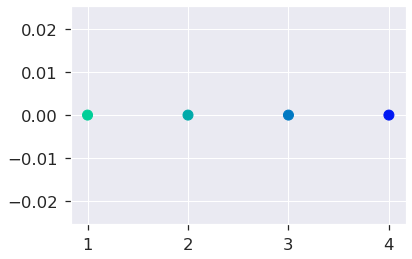

In [7]:
# c = 'ocean_r'
c = 'winter_r'
# c = 'rainbow'
cmap = sb.color_palette(c)
cmap20 = sb.color_palette(c, 20)
cmap4 = cmap20[2:18:4]
# cmap4 = [cmap20[2], cmap20[4], cmap20[8], cmap20[12]] # for ocean_r
# cmap4 = [cmap20[2], cmap20[8], cmap20[12], cmap20[15]] # for winter
# cmap4 = [cmap20[5], cmap20[8], cmap20[12], cmap20[16]] # for winter_r
cmap4 = [cmap20[3], cmap20[6], cmap20[10], cmap20[18]] # for winter_r, alt
# cmap4 = [cmap20[1], cmap20[6], cmap20[14], cmap20[19]] # for rainbow
plt.scatter([[1],[2], [3], [4]], [[0], [0], [0], [0]], s=100, color=cmap4)

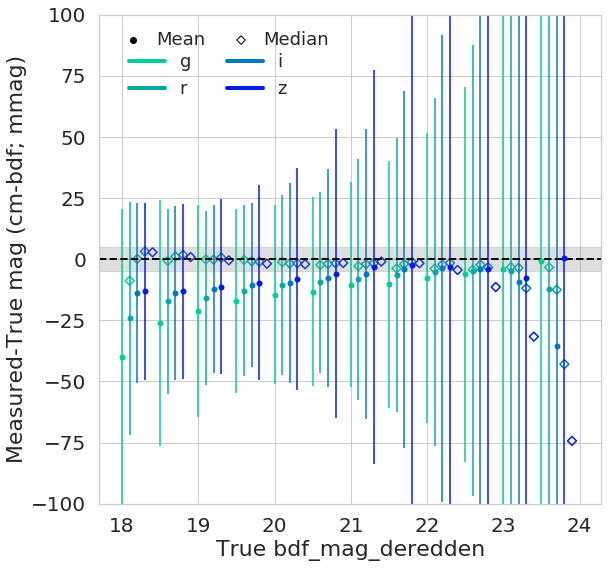

In [5]:
# plot_mean_mag_response(t_grid, name='Galaxy', corrected=True, run_name='run2-gridtest', title=False,
#                        ylim=[-100, 100], ylabel='grid', cmap=cmap4, xmax=24)
plot_mean_mag_response_grid(t_grid, name='Galaxy', corrected=True, run_name='run2-gridtest', title=False,
                       ylim=[-100, 100], ylabel='grid', cmap=cmap4, xmax=24, use_one_error=False)
plt.gcf().savefig('./figs/gridtest-mag-response.pdf', bbox_inches='tight')

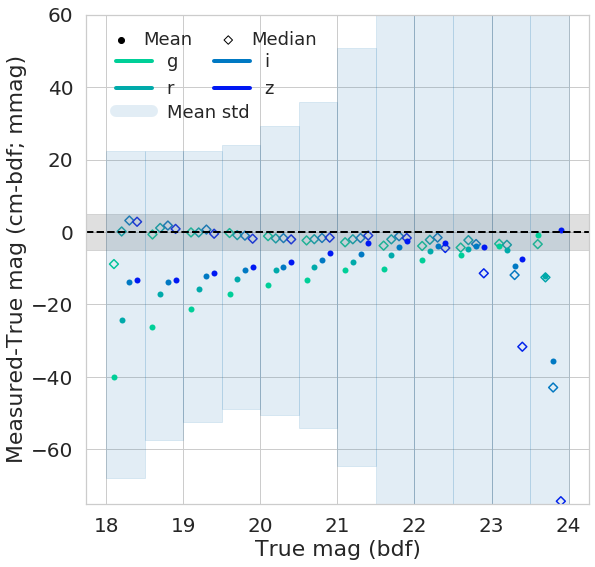

In [12]:
# plot_mean_mag_response(t_grid, name='Galaxy', corrected=True, run_name='run2-gridtest', title=False,
#                        ylim=[-100, 100], ylabel='grid', cmap=cmap4, xmax=24)
plot_mean_mag_response_grid(t_grid, name='Galaxy', corrected=True, run_name='run2-gridtest', title=False,
                       ylim=[-75, 60], ylabel='grid', cmap=cmap4, xmax=24, use_one_error=True)
plt.gcf().savefig('./figs/gridtest-mag-response.pdf', bbox_inches='tight')

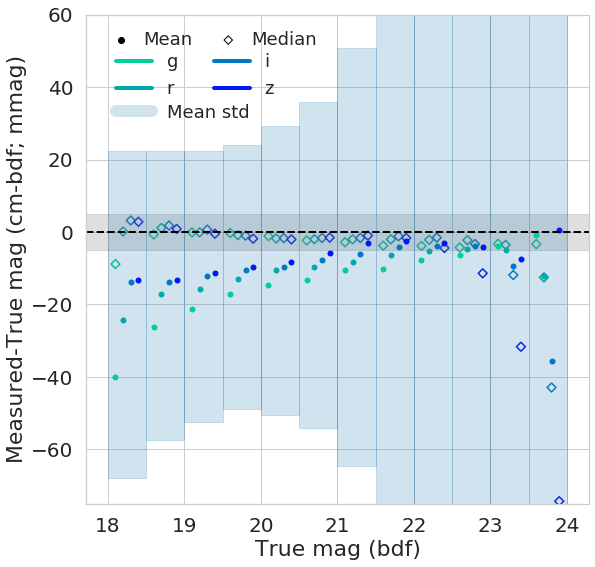

In [18]:
## Variant of the above to make updates for paper reviewer revisions

# plot_mean_mag_response(t_grid, name='Galaxy', corrected=True, run_name='run2-gridtest', title=False,
#                        ylim=[-100, 100], ylabel='grid', cmap=cmap4, xmax=24)
plot_mean_mag_response_grid(t_grid, name='Galaxy', corrected=True, run_name='run2-gridtest', title=False,
                       ylim=[-75, 60], ylabel='grid', cmap=cmap4, xmax=24, use_one_error=True, bar_alpha=0.2)
plt.gcf().savefig('./figs/gridtest-mag-response_revised.pdf', bbox_inches='tight')

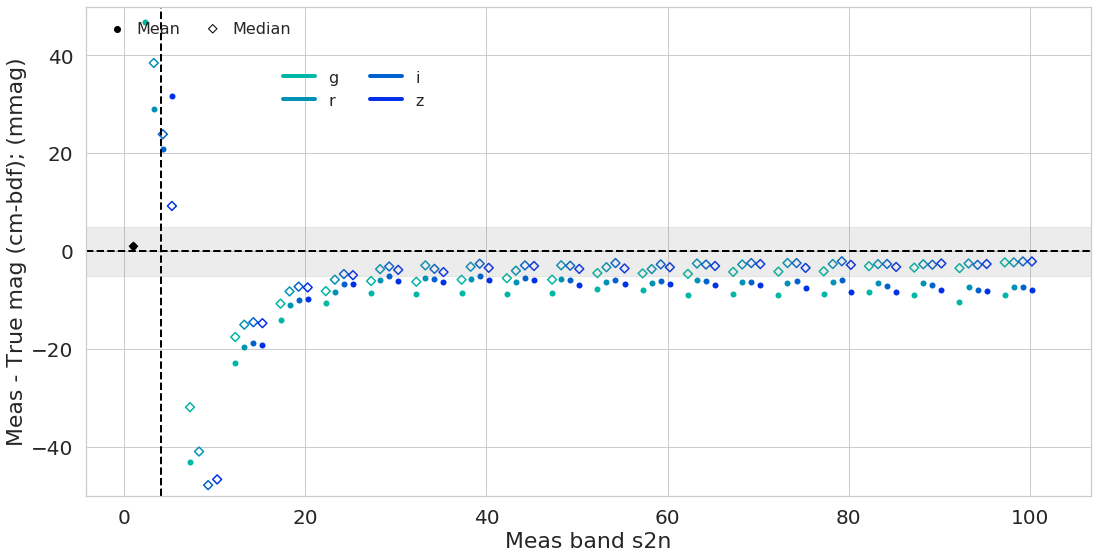

In [34]:
dt = True
if dt is True:
    lt = '_dt'
else:
    lt = ''
t_grid_s2n_file = f'./tables/grid-gal-scatter-mag-stats-deredden-s2n.fits'
t_grid_s2n = Table.read(t_grid_s2n_file)
plot_mean_mag_response(t_grid_s2n, name='Galaxy', corrected=True, run_name='run2-gridtest', title=False,
                       ylim=[-50, 50], ylabel='grid', cmap=cmap4, use_one_error=True, x_type='s2n')

In [29]:
t_grid_s2n

mean_g,med_g,std_g,bin_mean_g,mean_r,med_r,std_r,bin_mean_r,mean_i,med_i,std_i,bin_mean_i,mean_z,med_z,std_z,bin_mean_z
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.04681743130851211,0.059409876292413344,0.8140056393827464,2.5,0.02912792060214873,0.03846918208540018,0.5018865579031148,2.5,0.020803294175170736,0.023898630733379278,0.36774176603744746,2.5,0.03172877203778583,0.009242483180727845,0.4566571821531725,2.5
-0.0430614690546611,-0.03188445658049943,0.18140888330435426,7.5,-0.05060075025679135,-0.04095346223855856,0.184167180505582,7.5,-0.060182283801022404,-0.04781942675124995,0.19079873963222543,7.5,-0.0622063575423754,-0.046647250106078175,0.19285014348232274,7.5
-0.022763718608637292,-0.017544900816419684,0.10849544522158579,12.5,-0.01949436563747567,-0.015023920786347844,0.10752244951664917,12.5,-0.018772445066624496,-0.014517261665197623,0.1079994379447933,12.5,-0.019156612572834103,-0.014714949708857006,0.10579006653466325,12.5
-0.014068486607476529,-0.010724352996600572,0.07566741709979989,17.5,-0.01108655752172566,-0.008223480074150302,0.07756110055110362,17.5,-0.009947151064085563,-0.007245974317328319,0.07819836139221344,17.5,-0.00971492966734596,-0.00741058694147867,0.07489440336429236,17.5
-0.010499967570959362,-0.008157764759570085,0.05851101743754195,22.5,-0.008361331287349307,-0.0058184973312975785,0.0609770870683971,22.5,-0.006700459597241838,-0.004671019287856737,0.06023830995306018,22.5,-0.006784367009000029,-0.004898796891762203,0.05927051657647975,22.5
-0.008481780255079823,-0.006098609758687701,0.05065806497903614,27.5,-0.005886013677598294,-0.003675102879938663,0.04997796312905769,27.5,-0.005164107649067316,-0.003127128699610182,0.051340138655527646,27.5,-0.0060482429776474375,-0.003823958934574989,0.050124304537821164,27.5
-0.008747099567790883,-0.0062519426557070545,0.0434158848087897,32.5,-0.005412267453560796,-0.0029069789759894604,0.0444928694118576,32.5,-0.005618792389947723,-0.0036158263688221837,0.04474423353337644,32.5,-0.006333672152505311,-0.004277419888989442,0.044260096394841936,32.5
-0.00864854499041484,-0.005834443727417593,0.039382418548899345,37.5,-0.005629009023390227,-0.0031777116385445225,0.04026730417806024,37.5,-0.005097242340859224,-0.002561333022931933,0.04042679503916444,37.5,-0.005869547009855802,-0.0034032733091997613,0.03962643630124622,37.5
-0.008707162751575652,-0.0055246433436817455,0.03671692259545048,42.5,-0.006283758227382097,-0.003987130394847327,0.03734940826554349,42.5,-0.0054603225132563325,-0.0029036545896126142,0.0364483793052993,42.5,-0.005934667179792548,-0.00302251518353458,0.03551389675615392,42.5


In [ ]:
plot_mean_mag_response(t_grid, name='Galaxy', corrected=True, run_name='run2-gridtest', title=False, ylim=[-100, 100], ylabel='grid', cmap='tab10', xmax=24)
# plt.gcf().savefig('./figs/gridtest-mag-response.pdf', bbox_inches='tight')

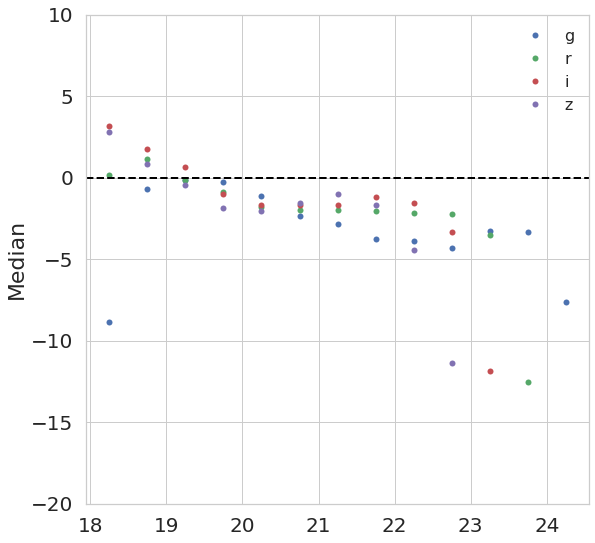

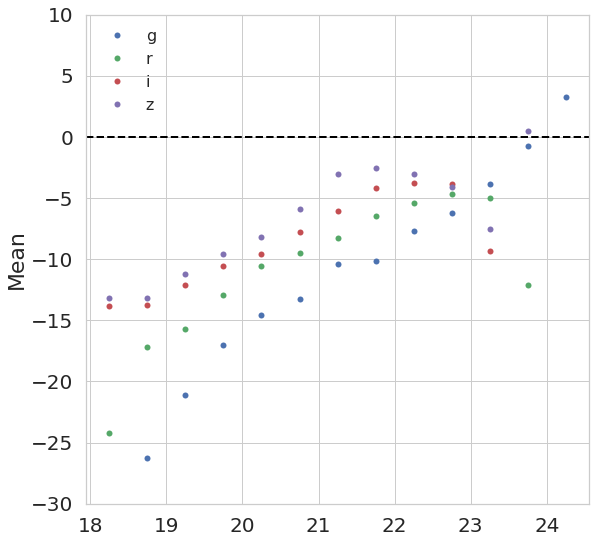

In [90]:
for b in 'griz':
    plt.plot(t_grid[f'bin_mean_{b}'], t_grid[f'med_{b}']*1000, 'o', label=b)
    
plt.axhline(0, lw=2, ls='--', c='k')
    
plt.legend()
plt.gcf().set_size_inches(9,9)
plt.ylim(-20, 10)
plt.ylabel('Median')
plt.show()

for b in 'griz':
    plt.plot(t_grid[f'bin_mean_{b}'], t_grid[f'mean_{b}']*1000, 'o', label=b)
    
plt.axhline(0, lw=2, ls='--', c='k')
    
plt.legend()
plt.gcf().set_size_inches(9,9)
plt.ylim(-30, 10)
plt.ylabel('Mean')
plt.show()

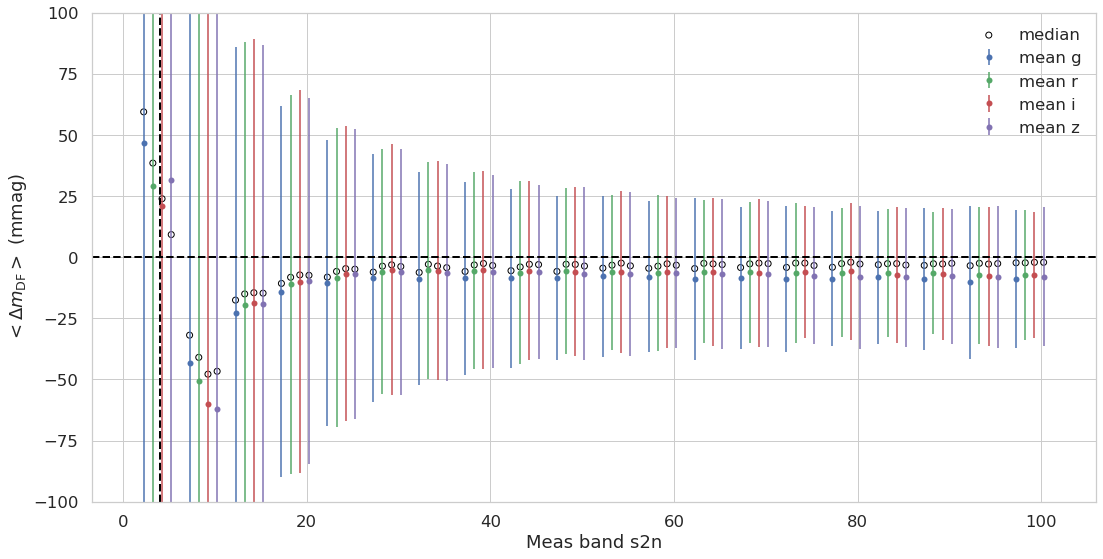

In [30]:
t_grid_s2n_file = './tables/grid-gal-scatter-mag-stats-deredden-s2n.fits'
t_grid_s2n = Table.read(t_grid_s2n_file)
plot_mean_mag_response(t_grid_s2n, name='Galaxy', corrected=True, ylim=[-100, 100], x_type='s2n', title=False)

## Colors

In [4]:
def plot_mean_color_response(t, name, corrected, ylim=[-.5, .5], x_type='mag', run_name='', title=True, mmag=True, errors=True):
    sb.set_style("whitegrid")
    
    colors = ['tab:green', 'tab:orange', 'tab:blue', 'tab:purple']

#     mmin, mmax = 18, 24.5
#     dm = 0.5
#     mags = np.arange(mmin, mmax+dm, dm)

#     x = np.mean([mags[:-1], mags[1:]], axis=0)

    med_marker = 'D' # For median

    if x_type == 'mag':
        dx = .0175
    elif x_type == 's2n':
        dx = 1
        
    if mmag is True:
        sf = 1000.
        mlabel = 'mmag'
    else:
        sf = 1.
        mlabel = 'mag'

    k = 0
    for b in 'griz':
        if b == 'z':
            break
        blabel = 'griz'[k] + '-' + 'griz'[k+1]
        xbin = t[f'bin_mean_{b}'] - 0.25
        if errors is True:
            plt.errorbar(xbin + dx*k, sf*t[f'mean_{b}'], sf*t[f'std_{b}'], label=f'mean {blabel}', fmt='o', color=colors[k])
        else:
            plt.plot(xbin + dx*k, sf*t[f'mean_{b}'], 'o', label=f'mean {blabel}')

        if k == 0:
            lab = 'median'
        else:
            lab = None
        plt.scatter(xbin + dx*k, sf*t[f'med_{b}'], facecolor='none', ec=colors[k], label=lab, marker=med_marker)

        k += 1

    plt.axhline(0, lw=2, ls='--', c='k')

    if corrected is True:
        l = '_deredden'
    else:
        l = ''
        
    if name == 'Galaxy':
        if x_type == 'mag':
            plt.xlabel(f'True bdf color')
        elif x_type == 's2n':
            plt.xlabel(f'Meas band s2n')
        plt.ylabel(r'$<\Delta c_\mathrm{DF}>$ ' +f'({mlabel})')
    elif name == 'Star':
        if x_type == 'mag':
            plt.xlabel(r'True $\delta$-color')
        elif x_type == 's2n':
            plt.xlabel(f'Meas band s2n')
        plt.ylabel(r'$<\Delta c_\delta>$ ' +f'({mlabel})')
        
    plt.ylim(ylim)
    
    s = 9
    
    if x_type == 'mag':
        plt.gcf().set_size_inches(2*s, s)
        loc = 'upper left'
    elif x_type == 's2n':
        plt.axvline(5-dx, lw=2, ls='--', c='k')
        plt.gcf().set_size_inches(2*s, s)
        loc = 'upper right'
        
    plt.legend(loc=loc)

    if title is True:
        plt.title(f'Balrog {run_name} {name} Magnitude Response')
        
    return

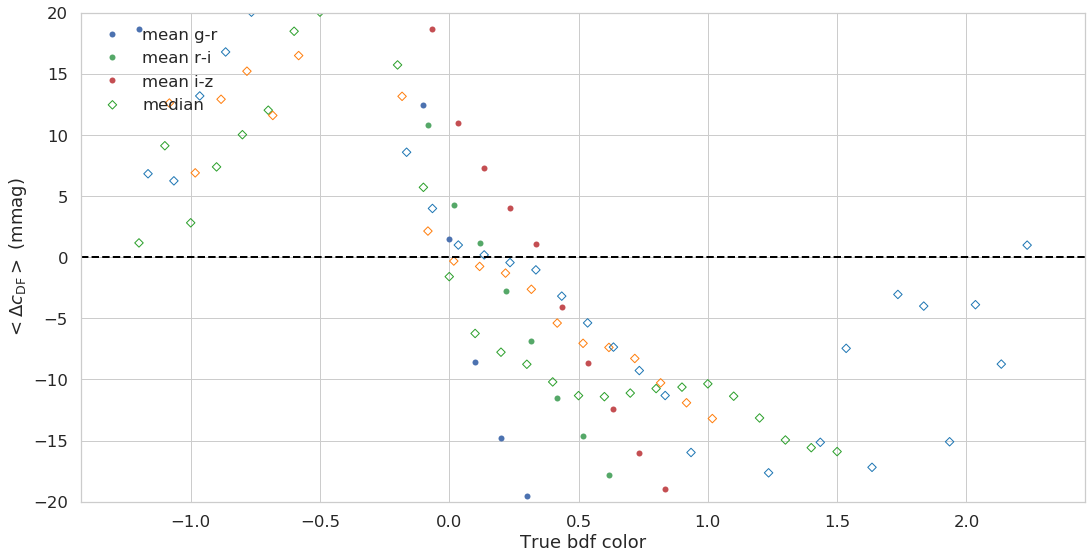

In [9]:
galaxy_color_file = './tables/gal-scatter-color-stats-deredden.fits'
galaxy_color = Table.read(galaxy_color_file)
plot_mean_color_response(galaxy_color, name='Galaxy', corrected=True, title=False, ylim=[-20, 20], mmag=True, errors=False)

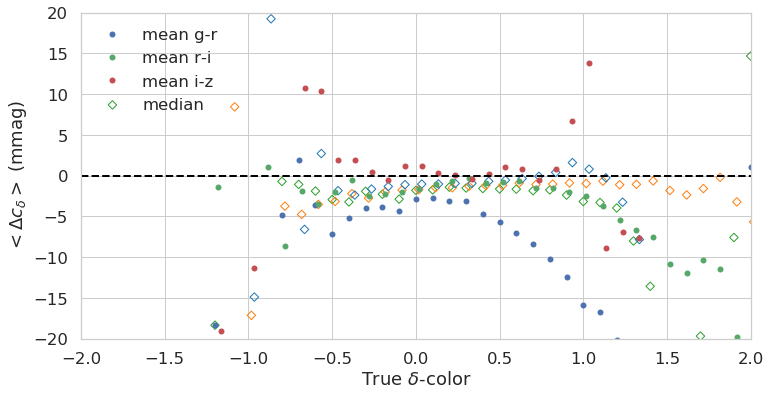

In [6]:
star_color_file = './tables/star-scatter-color-stats-deredden.fits'
star_color = Table.read(star_color_file)
plot_mean_color_response(star_color, name='Star', corrected=True, title=False, ylim=[-20, 20], mmag=True, errors=False)
plt.xlim([-2, 2])
plt.gcf().set_size_inches(12, 6)

In [5]:
star_color

<Table length=0>
<No columns>

In [197]:
bal = Table.read('/project/projectdirs/des/severett/Balrog/paper-plots/cats/balrog_sof_galaxy_compare.fits')

Text(0.5, 0, 'true_gap_flux_fwhm4asec')

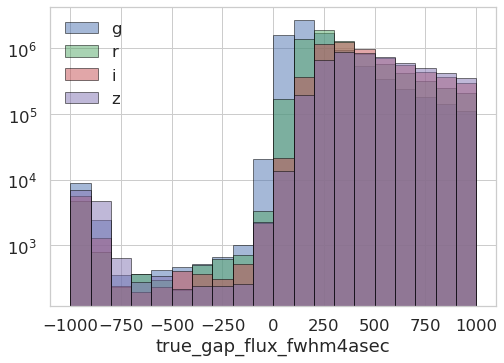

In [163]:
bins = np.arange(-1000, 1000+100, 100)
for i in range(4):
    plt.hist(b['true_gap_flux_fwhm4asec'][:,i], ec='k', alpha=0.5, label='griz'[i], bins=bins)
plt.legend()
plt.yscale('log')
plt.xlabel('true_gap_flux_fwhm4asec')

0
1
2
3


Text(0.5, 1.0, 'Objects where true i-band gap_flux < -100')

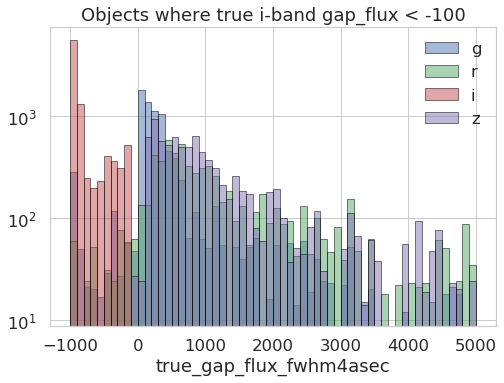

In [182]:
# cuts = np.where( (b['true_gap_flux_fwhm4asec'][:,2] < -100) )

bins = np.arange(-1000, 5000+100, 100)
for i in range(4):
    print(i)
    plt.hist(b['true_gap_flux_fwhm4asec'][:,i][cuts], ec='k', alpha=0.5, label='griz'[i], bins=bins)
plt.legend()
plt.yscale('log')
plt.xlabel('true_gap_flux_fwhm4asec')
plt.title('Objects where true i-band gap_flux < -100')

Text(0, 0.5, 'Meas-True g-mag (cm-bdf)')

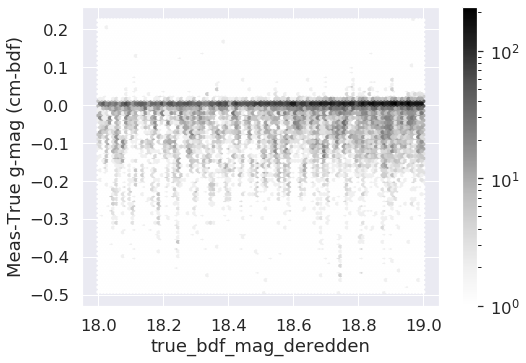

In [217]:
xx = bal['true_bdf_mag_deredden'][:,0]
yy = bal['meas_cm_mag_deredden'][:,0] - xx
cuts = np.where( (xx > 18) & (xx <= 19) & (yy > -0.5) & (yy<0.25))

bright = bal[cuts]
xx = xx[cuts]
yy = yy[cuts]

plt.hexbin(xx, yy, norm=LogNorm(), gridsize=100)
plt.colorbar()
plt.xlabel('true_bdf_mag_deredden')
plt.ylabel('Meas-True g-mag (cm-bdf)')

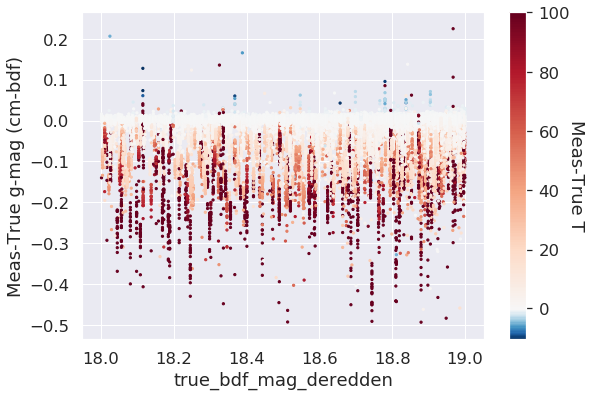

In [239]:
xx = bal['true_bdf_mag_deredden'][:,0]
yy = bal['meas_cm_mag_deredden'][:,0] - xx
cuts = np.where( (xx > 18) & (xx <= 19) & (yy > -0.5) & (yy<0.25))

bright = bal[cuts]
xx = xx[cuts]
yy = yy[cuts]

c = bright['meas_cm_T'] - bright['true_bdf_T']

plt.scatter(xx, yy, c=c, s=5, norm=MidpointNormalize(-10, 100, 0), cmap='RdBu_r')
cbar = plt.colorbar()
cbar.set_label('Meas-True T', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
plt.xlabel('true_bdf_mag_deredden')
plt.ylabel('Meas-True g-mag (cm-bdf)')

plt.gcf().set_size_inches(9, 6)

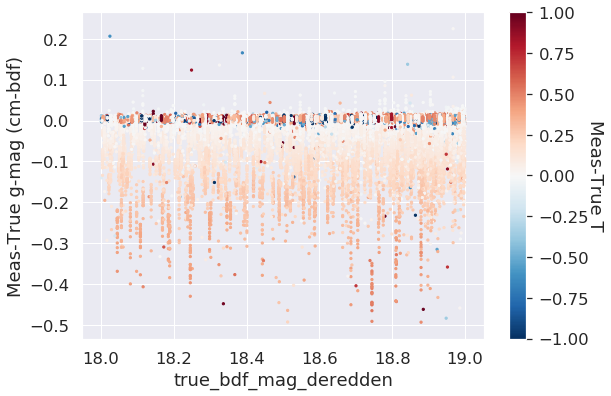

In [240]:
xx = bal['true_bdf_mag_deredden'][:,0]
yy = bal['meas_cm_mag_deredden'][:,0] - xx
cuts = np.where( (xx > 18) & (xx <= 19) & (yy > -0.5) & (yy<0.25))

bright = bal[cuts]
xx = xx[cuts]
yy = yy[cuts]

c = bright['meas_cm_fracdev'] - bright['true_bdf_fracdev']

plt.scatter(xx, yy, c=c, s=5, norm=MidpointNormalize(-1, 1, 0), cmap='RdBu_r')
cbar = plt.colorbar()
cbar.set_label('Meas-True T', rotation=270)
cbar.ax.get_yaxis().labelpad = 15
plt.xlabel('true_bdf_mag_deredden')
plt.ylabel('Meas-True g-mag (cm-bdf)')

plt.gcf().set_size_inches(9, 6)

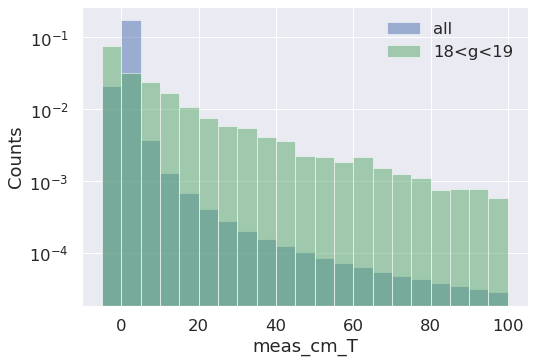

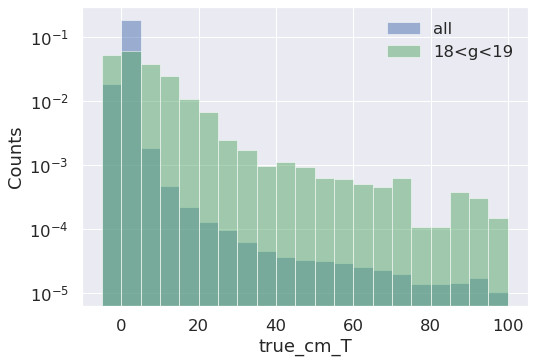

In [247]:
bins = np.arange(-5, 105, 5)
plt.hist(bal['meas_cm_T'], label='all', bins=bins, density=True, alpha=0.5)
plt.hist(bright['meas_cm_T'], label='18<g<19', bins=bins, density=True, alpha=0.5)
plt.yscale('log')
plt.xlabel('meas_cm_T')
plt.ylabel('Counts')
plt.legend()
plt.show()

bins = np.arange(-5, 105, 5)
plt.hist(bal['true_bdf_T'], label='all', bins=bins, density=True, alpha=0.5)
plt.hist(bright['true_bdf_T'], label='18<g<19', bins=bins, density=True, alpha=0.5)
plt.yscale('log')
plt.xlabel('true_cm_T')
plt.ylabel('Counts')
plt.legend()
plt.show()

bins = np.arange(-5, 105, 5)
plt.hist(bal['true_bdf_T'], label='all', bins=bins, density=True, alpha=0.5)
plt.hist(bright['true_bdf_T'], label='18<g<19', bins=bins, density=True, alpha=0.5)
plt.yscale('log')
plt.xlabel('true_cm_T')
plt.ylabel('Counts')
plt.legend()
plt.show()

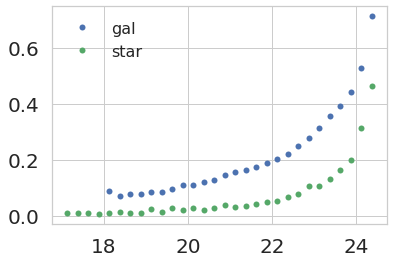

In [49]:
plt.plot(t_gal['bin_mean_i'], t_gal['std_i'], 'o', label='gal')
plt.plot(t_star['bin_mean_i'], t_star['std_i'], 'o', label='star')
plt.legend()

4.367829760571231
2.0001795526347284


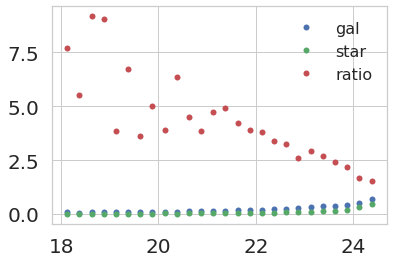

In [53]:
cuts = np.where(t_star['bin_mean_i'] >= 18)
plt.plot(t_gal['bin_mean_i'], t_gal['std_i'], 'o', label='gal')
plt.plot(t_star['bin_mean_i'][cuts], t_star['std_i'][cuts], 'o', label='star')
ratio = t_gal['std_i'] /  t_star['std_i'][cuts]
plt.plot(t_gal['bin_mean_i'], ratio, 'o', label='ratio')
plt.legend()
print(np.mean(ratio))
print(np.std(ratio))

In [54]:
np.max(ratio)

9.181578160297107

In [ ]:
s = 